# Bike Sharing Data Science Project

This notebook outlines the analysis and model development process for the Bike Sharing Dataset. It encompasses the following stages:
- About the Bike Sharing Dataset
- Descriptive Analysis
- Missing Value Analysis
- Outlier Analysis
- Correlation Analysis
- Overview metrics
- Model Selection
    - Closedform Solution
    - Closedform Solution with Regularization
    - Linear Regression using Gradient Decent
    - Linear Regression with Regularization using Gradient Decent
    - Lasso Regression using Gradient Decent
    - Lasso Regression using Stochastic Gradient Decent
- Conclusion


## Regarding the Bike Sharing Dataset

### Overview

Bike sharing systems represent an innovative evolution of traditional bike rentals, automating the entire process, including membership, rental, and return. Users can effortlessly rent a bike from a specific location and return it to another. With over 500 bike-sharing programs worldwide, encompassing more than 500,000 bicycles, these systems play a pivotal role in addressing traffic, environmental, and health concerns.

Beyond their practical applications, the data generated by bike sharing systems is highly appealing for research. In contrast to other transportation services like buses or subways, these systems explicitly record travel durations, departure and arrival positions. This unique characteristic transforms bike sharing systems into virtual sensor networks, offering valuable insights into city mobility. As a result, it is anticipated that monitoring these data can help detect significant events and patterns within the urban landscape.

### Attribute Information


- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    

- temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import random
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Make results reproducible
random.seed(100)

## Descriptive Analysis

In [42]:
# reading the data
df = pd.read_csv('/content/hour.csv')

In [43]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Provide data set splits for training, validation, and testing:

In [44]:
# Denormalization function
def denormalize_temperature(normalized_temp, t_min=-8, t_max=39):
    denormalized_temp = (normalized_temp * (t_max - t_min)) + t_min
    return denormalized_temp

In [45]:
# Apply denormalization vallues
df['temp'] = df['temp'].apply(denormalize_temperature)
df['atemp'] = df['atemp'].apply(denormalize_temperature)
df['hum'] = df['hum'] * 100
df['windspeed'] = df['windspeed'] * 67

In [46]:
# Split the data into train, validation, and test sets
# You can customize the split ratios as needed
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

df_train = df[:train_size]
df_test = df[train_size:]

categorical_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']

features= categorical_features + numerical_features
df_target = ['cnt']

Get column names of the pandas data frame:

In [47]:
print(list(df.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


#### Describing Numerical Data

In [48]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17379.0,15.358397,9.050138,-7.06,7.9800,15.5000,23.0200,39.0000
atemp,17379.0,14.361430,8.076960,-8.00,7.6651,14.7856,21.1964,39.0000
hum,17379.0,62.722884,19.292983,0.00,48.0000,63.0000,78.0000,100.0000
windspeed,17379.0,12.736540,8.196795,0.00,7.0015,12.9980,16.9979,56.9969


In [49]:
for col in categorical_features:
    df[col] = df[col].astype('category')
df[categorical_features].describe().T

,count,unique,top,freq
season,17379,4,3,4496
holiday,17379,2,0,16879
mnth,17379,12,5,1488
hr,17379,24,17,730
weekday,17379,7,6,2512
workingday,17379,2,1,11865
weathersit,17379,4,1,11413


## Checking for Missing Values

In [50]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,instant,weathersit,registered,casual,windspeed,hum,atemp,temp,workingday,dteday,weekday,holiday,hr,mnth,yr,season,cnt
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA Exploratory Data Analysis

<Axes: ylabel='cnt'>

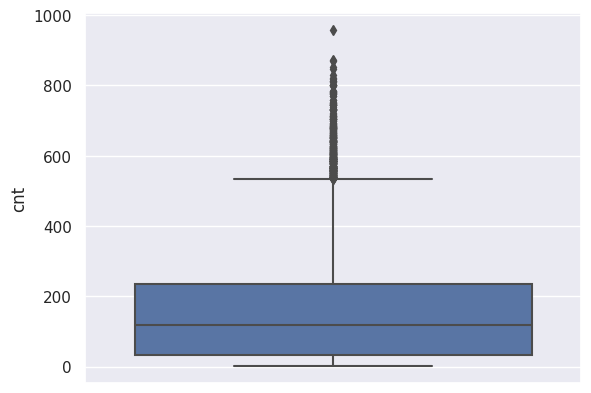

In [51]:
sns.set(font_scale=1.0)
sns.boxplot(data=df_train,y="cnt",orient="v")

In [52]:
# Function for Boxplot
def box_plot(df, column,title, figure_size=(6,4)):
    plt.figure(figsize=figure_size)
    sns.boxplot(y=df_train['cnt'],data=df,x=column).set_title(title)
    plt.show()

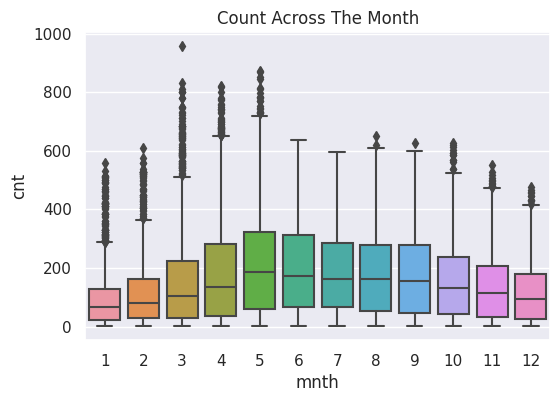

In [53]:
box_plot(df_train, 'mnth', 'Count Across The Month')

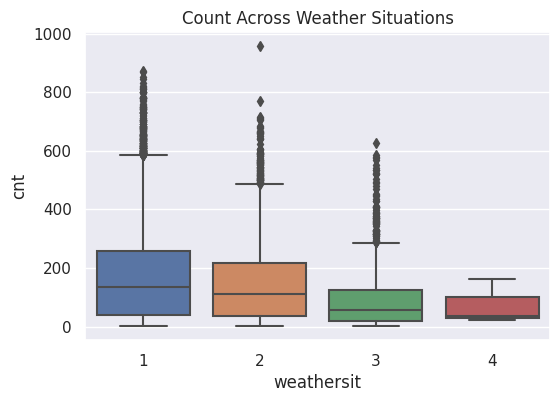

In [54]:
box_plot(df_train, 'weathersit', 'Count Across Weather Situations')

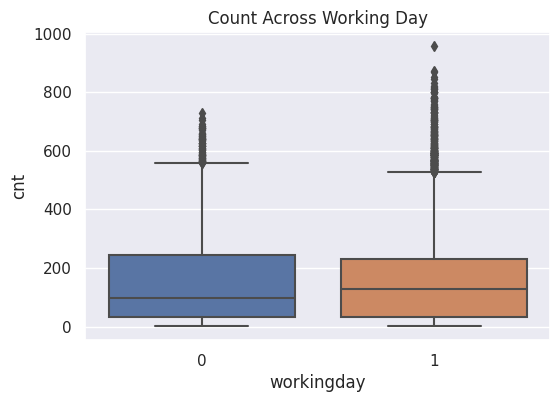

In [55]:
box_plot(df_train, 'workingday', 'Count Across Working Day')

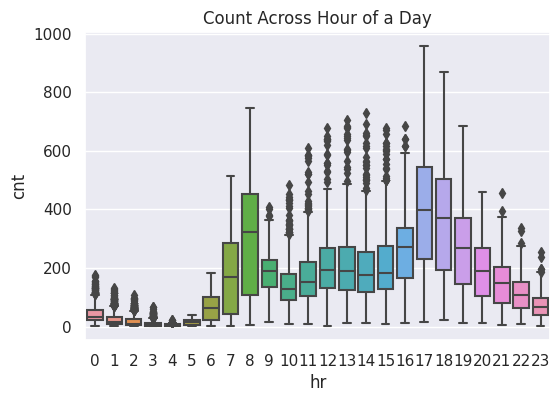

In [56]:
box_plot(df_train, 'hr', 'Count Across Hour of a Day')

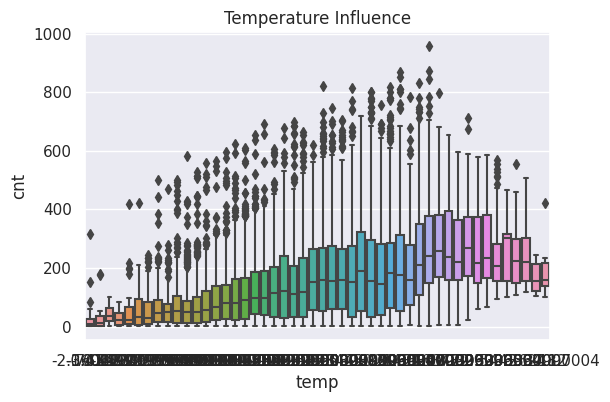

In [57]:
box_plot(df_train, 'temp', 'Temperature Influence')

#### Interpretation:

The box plots for working days and holidays reveal that bike rentals are higher on regular workdays compared to weekends or holidays. Hourly box plots show peaks at 8 am and 5 pm, suggesting users primarily rent bikes for commuting to work or school. Temperature is a crucial factor; higher temperatures correlate with increased rentals, while lower temperatures not only decrease the average but also result in more outliers in the data.

### Outliers Analysis

<ipython-input-58-592587b4a459>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[df_target[-1]]);


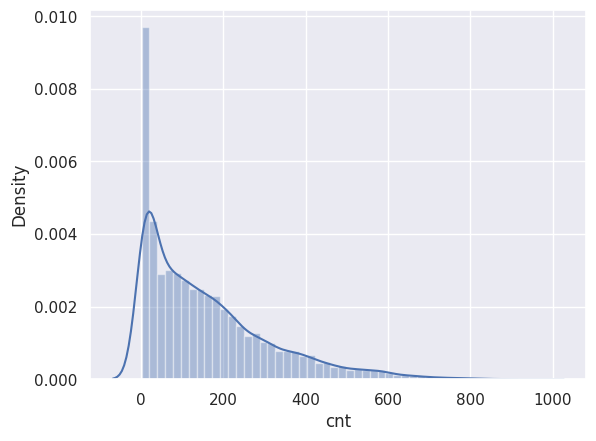

In [58]:
# distribution of train data
sns.distplot(df_train[df_target[-1]]);

The distribution plot for count values indicates a departure from a normal distribution. To address outliers, we'll employ the median and interquartile range (IQR) for removal. An alternative method involves transforming target values to achieve a normal distribution and using mean and standard deviation.

Train set samples including outliers: 12165
Train set samples excluding outliers: 11783


<ipython-input-59-98c5c848ea20>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train_prep.cnt);


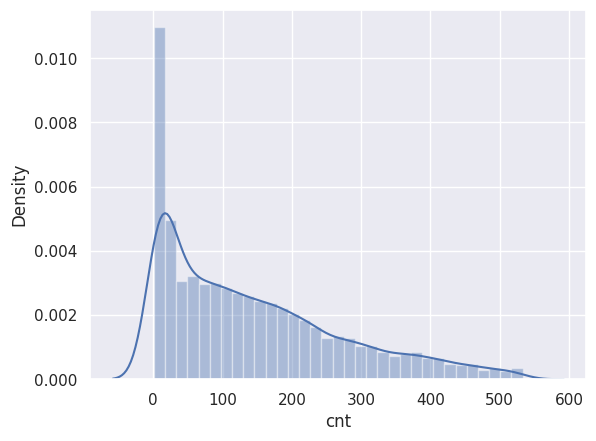

In [59]:
print("Train set samples including outliers: {}".format(len(df_train)))
q1 = df_train.cnt.quantile(0.25)
q3 = df_train.cnt.quantile(0.75)
IQR = q3 - q1
lower_bound = q1 -(1.5 * IQR)
upper_bound = q3 +(1.5 * IQR)
df_train_prep = df_train.loc[(df_train.cnt >= lower_bound) & (df_train.cnt <= upper_bound)]
print("Train set samples excluding outliers: {}".format(len(df_train_prep)))
sns.distplot(df_train_prep.cnt);

In [60]:
df_train_prep

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,3.28,5.5313,81.0,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,2.34,4.8169,80.0,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,2.34,4.8169,80.0,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,3.28,5.5313,75.0,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,3.28,5.5313,75.0,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,12161,2012-05-26,2,1,5,21,0,6,0,2,25.84,24.0446,62.0,12.9980,100,151,251
12161,12162,2012-05-26,2,1,5,22,0,6,0,1,24.90,23.3349,74.0,16.9979,86,118,204
12162,12163,2012-05-26,2,1,5,23,0,6,0,1,24.90,23.3349,74.0,16.9979,36,114,150
12163,12164,2012-05-27,2,1,5,0,0,0,0,2,23.96,21.9108,69.0,11.0014,48,89,137


In [61]:
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11783 entries, 0 to 12164
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     11783 non-null  int64  
 1   dteday      11783 non-null  object 
 2   season      11783 non-null  int64  
 3   yr          11783 non-null  int64  
 4   mnth        11783 non-null  int64  
 5   hr          11783 non-null  int64  
 6   holiday     11783 non-null  int64  
 7   weekday     11783 non-null  int64  
 8   workingday  11783 non-null  int64  
 9   weathersit  11783 non-null  int64  
 10  temp        11783 non-null  float64
 11  atemp       11783 non-null  float64
 12  hum         11783 non-null  float64
 13  windspeed   11783 non-null  float64
 14  casual      11783 non-null  int64  
 15  registered  11783 non-null  int64  
 16  cnt         11783 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 1.6+ MB


## Correlation Analysis

<Axes: >

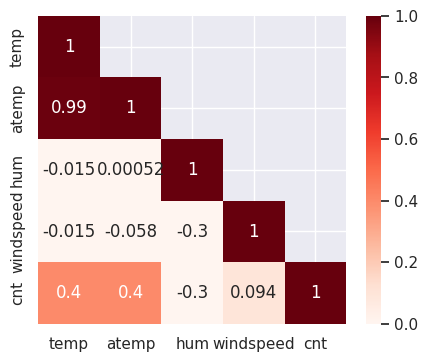

In [62]:
matrix_cor = df_train[numerical_features + df_target].corr()
heat = np.array(matrix_cor)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(5,4)
sns.set(font_scale=1.0)
sns.heatmap(matrix_cor, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

#### In conclusion, the descriptive analysis chapter yields the following observations:

- "Casual" and "registered" directly provide information about the bike sharing count, leading to potential data leakage, and are therefore excluded from the feature set.
- Due to strong correlation, the feature "atemp" is eliminated to streamline the predictive model and reduce dimensionality.
- "hr" (hour) and "temp" (temperature) emerge as promising features for predicting bike sharing counts.

In [63]:
features.remove('atemp')

In [64]:
print(features)

['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']


## Overview Metrics

### Mean Squared Error (MSE)

MSE = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i) - \log(y_i))^2 }$

### $R^2$ Score

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

## Model Selection

The characteristics of the given problem are:

- __Regression:__ The target variable is a quantity.
- __Small dataset:__ Less than 100K samples.
- __Few features should be important:__ The correlation matrix indicates that a few features contain the information to predict the target variable.

This characteristic makes the following methods most promising: Ridge Regression, Support Vector Regression, Ensemble Regressor, Random Forest Regressor.

We will evaluate the performance of these models in the following:

### Linear Regression

In [65]:
X = pd.concat([df_train_prep[features],df_test[features]], ignore_index=True)
y = pd.concat([df_train_prep.cnt,df_test.cnt ], ignore_index=True)

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16997 entries, 0 to 16996
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      16997 non-null  int64  
 1   holiday     16997 non-null  int64  
 2   mnth        16997 non-null  int64  
 3   hr          16997 non-null  int64  
 4   weekday     16997 non-null  int64  
 5   workingday  16997 non-null  int64  
 6   weathersit  16997 non-null  int64  
 7   temp        16997 non-null  float64
 8   hum         16997 non-null  float64
 9   windspeed   16997 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 1.3 MB


In [67]:
class LinearRegression:
    def __init__(self, X, y, learning_rate, epsilon, batch_size, max_iteration, reg_term, gd = False, sgd = False):
      self.X = X
      self.y = y
      self.learning_rate = learning_rate
      self.epsilon = epsilon
      self.max_iteration = max_iteration
      self.gd = gd
      self.sgd = sgd
      self.batch_size = batch_size
      self.reg_term = reg_term

    def split_date(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state = 42)
      return X_train, X_test, y_train, y_test

    def add_X0(self, X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):
      mean = np.mean(X, axis = 0)
      std = np.std(X, axis = 0)
      X = (X-mean)/std
      X = self.add_X0(X)
      return X, mean, std

    def normalize_test(self, X, mean, std):
      X = (X - mean)/std
      X = self.add_X0(X)
      return X

    def rank(self, X):
      #u, s, v = np.linalg.svd(X)
      rank = np.linalg.matrix_rank(X)
      return rank

    def check_fullRank(self, X):
      rank = self.rank(X)
      if rank == min(X.shape):
        print('Matrix is Full rank')
        self.fullRank = True
      else:
        print('Matrix is Full rank')
        self.fullRank = False

    def check_lowRank(self, X):
      if(X.shape[1] > X.shape[0]):
        print('Matrix is low rank')
        self.lowRank = True
      else:
        print('Matrix is Low rank')
        self.lowRank = False

    def normal_equation(self, X, y):
      A = X.T.dot(X)
      I = np.eye(A.shape[0])
      self.theta = np.linalg.inv(A + self.reg_term * I).dot(X.T).dot(y)

    def predict(self, X):
      return X.dot(self.theta)

    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y)**2).sum()

    def rmse(self, X, y):
      rmse = np.sqrt(self.sse(X,y) / X.shape[0])
      return rmse

    def cost_function(self, X, y):
      return self.sse(X, y)/2

    def cost_derivative(self, X, y):
      y_hat = self.predict(X)
      return (y_hat-y).dot(X)+(self.reg_term * self.theta)

    def gradient_descent(self, X, y):
      self.errors = []
      last_error = np.inf
      for t in tqdm(range(self.max_iteration)):
        self.theta -= self.learning_rate * self.cost_derivative(X, y)
        error = self.rmse(X, y)
        self.errors.append(error)
        if np.abs(last_error - error) < self.epsilon:
          print('Model Stopped Learning')
          break
        last_error = error



    def fit(self):
      self.X_train, self.X_test, self.y_train, self.y_test = self.split_date()
      self.X_train, mean, std = self.normalize_train(self.X_train)
      self.X_test = self.normalize_test(self.X_test, mean, std)

      self.check_fullRank(self.X_train)
      self.check_lowRank(self.X_train)

      if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
        self.normal_equation(self.X_train, self.y_train)
      else:
        if(self.gd):
          self.theta = np.ones(self.X_train.shape[1],dtype=np.float64)*0
          self.gradient_descent(self.X_train, self.y_train)
        elif(self.sgd):
          self.theta = np.ones(self.X_train.shape[1],dtype=np.float64)*0
          self.stochastic_gradient_descent(self.X_train, self.y_train)
      print(self.theta)
      sse_train = self.sse(self.X_train, self.y_train)
      sse_test = self.sse(self.X_test, self.y_test)
      rmse_train = self.rmse(self.X_train, self.y_train)
      rmse_test = self.rmse(self.X_test, self.y_test)
      print('Standard Square Error for training data: ',sse_train)
      print('Standard Square Error for testing data: ',sse_test)
      print('Root Mean Square Error for training data: ',rmse_train)
      print('Root Mean Square Error for tesing data: ',rmse_test)



In [68]:
# Closed form solution
print('Closed form solution')
linear_reg = LinearRegression (X = X, y = y, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000, reg_term = 0, batch_size = 100, gd = False, sgd = False)
linear_reg.fit()

Closed form solution
Matrix is Full rank
Matrix is Low rank
[ 1.81068673e+02  2.18666235e+01 -3.56490130e+00  4.45642536e+00
  4.90782256e+01  2.86743103e+00  2.37927796e-03 -1.75342559e-02
  5.35709224e+01 -3.99231459e+01  1.59528043e+00]
Standard Square Error for training data:  231518885.81252563
Standard Square Error for testing data:  94640696.79695824
Root Mean Square Error for training data:  139.50008783950952
Root Mean Square Error for tesing data:  136.22407779813594


In [69]:
# Closed form solution with regularization
print('Closed form solution with regularization')
linear_reg_regularization = LinearRegression(X = X, y = y, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000, reg_term = 10, batch_size = 100, gd = False, sgd = False)
linear_reg_regularization.fit()


Closed form solution with regularization
Matrix is Full rank
Matrix is Low rank
[ 1.80916604e+02  2.18315349e+01 -3.56327633e+00  4.48505536e+00
  4.90492451e+01  2.86544884e+00  6.13744075e-03 -3.80699222e-02
  5.35350443e+01 -3.98872411e+01  1.60679006e+00]
Standard Square Error for training data:  231519214.9722806
Standard Square Error for testing data:  94635955.3068077
Root Mean Square Error for training data:  139.5001870059301
Root Mean Square Error for tesing data:  136.2206653485495


In [70]:
#Gradient Descent
print('Gradient Descent')
linear_reg_gd = LinearRegression(X = X, y = y, learning_rate = 0.00005, epsilon = 0.5, max_iteration = 500, reg_term = 0, batch_size = 100, gd = True, sgd = False)
linear_reg_gd.fit()


Gradient Descent
Matrix is Full rank
Matrix is Low rank


  1%|          | 4/500 [00:00<00:01, 290.70it/s]

Model Stopped Learning
[179.09205574  18.42989334  -3.56566331   7.95557016  49.64415808
   2.86927156   0.48621441  -2.54157806  53.18565581 -37.24096631
   3.23375832]
Standard Square Error for training data:  231707892.94000036
Standard Square Error for testing data:  94664149.45125255
Root Mean Square Error for training data:  139.55701868496158
Root Mean Square Error for tesing data:  136.24095541215993


In [71]:
#Gradient Descent with regularization
print('Gradient Descent with regularization')
linear_reg_gd_r = LinearRegression(X = X, y = y, learning_rate = 0.000001, epsilon = 0.005, max_iteration = 500, reg_term = 10, batch_size = 100, gd = True, sgd = False)
linear_reg_gd_r.fit()

Gradient Descent with regularization
Matrix is Full rank
Matrix is Low rank


 54%|█████▍    | 272/500 [00:00<00:00, 683.18it/s]

Model Stopped Learning
[174.04142485  18.62672009  -3.54951373   8.1521709   48.81939688
   2.81358286   0.59851383  -3.10246536  52.20896588 -37.04534242
   3.58656113]
Standard Square Error for training data:  232316439.53016335
Standard Square Error for testing data:  94762291.1077776
Root Mean Square Error for training data:  139.74016147275864
Root Mean Square Error for tesing data:  136.31156001484936


# Lasso Regression Using Gradient Descent.

In [72]:
class LassoRegressionGradientDescent:

    def __init__(self, X, y, lasso_lambda=0.001, learning_rate=0.01, max_iterations=1000, epsilon=1e-6):
        self.X = X
        self.y = y
        self.lasso_lambda = lasso_lambda
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.epsilon = epsilon
        self.theta = None
        self.errors = []

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state = 42)
        return X_train, X_test, y_train, y_test

    def add_X0(self, X):
        """Add a column of ones to the feature matrix X"""
        return np.column_stack((np.ones((X.shape[0], 1)), X))

    def normalize_train(self, X):
        """Normalize training data and add a bias column"""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_normalized = (X - mean) / std
        X_normalized = self.add_X0(X_normalized)  # Add bias column
        return X_normalized, mean, std

    def normalize_test(self, X, mean, std):
        """Normalize test data using mean and std from training data"""
        X_normalized = (X - mean) / std
        return self.add_X0(X_normalized)

    def soft_threshold(self, rho, threshold):
        """Soft threshold function used for Lasso regularization"""
        return np.sign(rho) * np.maximum(np.abs(rho) - threshold, 0)

    def gradient_descent_lasso(self, X, y):
        n, p = X.shape
        theta = np.ones(p)  # Random initialization of theta
        prev_error = float(np.inf)

        for _ in tqdm(range(self.max_iterations), colour='red'):
            y_hat = X.dot(theta)
            errors = y_hat - y
            gradient = X.T.dot(errors) / n

            # Update rule with Lasso regularization term
            theta = self.soft_threshold(theta - self.learning_rate * gradient, self.learning_rate * self.lasso_lambda)

            error = np.sum(errors ** 2)
            self.errors.append(error)

            if abs(error - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = error

        plt.plot(self.errors)
        plt.xlabel('Iterations')
        plt.ylabel('Errors')
        plt.title('Lasso Regression Gradient Descent SSE')
        plt.show()

        self.theta = theta

    def fit(self):
        X_train, X_test, y_train, y_test = self.split_data()
        X_train_normalized, mean, std = self.normalize_train(X_train)
        X_test_normalized = self.normalize_test(X_test, mean, std)

        self.gradient_descent_lasso(X_train_normalized, y_train)

        sse_train = np.sum((X_train_normalized.dot(self.theta) - y_train) ** 2)
        rmse_train = np.sqrt(sse_train / X_train.shape[0])

        sse_test = np.sum((X_test_normalized.dot(self.theta) - y_test) ** 2)
        rmse_test = np.sqrt(sse_test / X_test.shape[0])

        print('/n')
        print("Training Data: SSE is {}, RMSE is {}".format(sse_train, rmse_train))
        print("Test Data: SSE is {}, RMSE is {}".format(sse_test, rmse_test))
        print(self.theta)

100%|██████████| 1000/1000 [00:01<00:00, 941.47it/s]


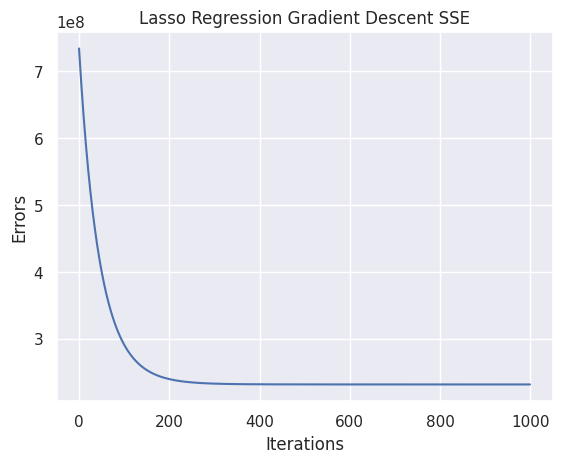

/n
Training Data: SSE is 231524121.84355536, RMSE is 139.50166529755623
Test Data: SSE is 94652566.78130972, RMSE is 136.23262024884
[ 1.81059899e+02  2.06934661e+01 -3.59350815e+00  5.55803623e+00
  4.91139323e+01  2.85741958e+00  2.34132740e-02 -1.61533707e-01
  5.37200603e+01 -3.97551417e+01  1.65240912e+00]


In [73]:
lasso_grad = LassoRegressionGradientDescent(X = X, y = y)
lasso_grad.fit()

# Lasso Regression Using Stochastic Gradient Descent.

In [74]:
class LassoRegressionSGD:

    def __init__(self, X, y, lasso_lambda=0.001, learning_rate=0.01, max_iterations=1000, epsilon=1e-6):
        self.X = X
        self.y = y
        self.lasso_lambda = lasso_lambda
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.epsilon = epsilon
        self.theta = None
        self.errors = []

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state = 42)
        return X_train, X_test, y_train.values, y_test.values

    def add_X0(self, X):
        """Add a column of ones to the feature matrix X"""
        return np.column_stack((np.ones((X.shape[0], 1)), X))

    def normalize_train(self, X):
        """Normalize training data and add a bias column"""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_normalized = (X - mean) / std
        X_normalized = self.add_X0(X_normalized)  # Add bias column
        return X_normalized, mean, std

    def normalize_test(self, X, mean, std):
        """Normalize test data using mean and std from training data"""
        X_normalized = (X - mean) / std
        return self.add_X0(X_normalized)

    def soft_threshold(self, rho, threshold):
        """Soft threshold function used for Lasso regularization"""
        return np.sign(rho) * np.maximum(np.abs(rho) - threshold, 0)

    def stochastic_gradient_descent_lasso(self, X, y):
        n, p = X.shape
        theta = np.ones(p)  # Random initialization of theta
        prev_error = float(np.inf)

        for _ in tqdm(range(self.max_iterations), colour='red'):
            for i in range(n):
                X_i = X[i, :]
                y_i = y[i]
                y_hat = X_i.dot(theta)
                error = y_hat - y_i
                gradient = X_i.T.dot(error)

                # Update rule with Lasso regularization term
                theta = self.soft_threshold(theta - self.learning_rate * gradient, self.learning_rate * self.lasso_lambda)

            # Calculate error for the entire dataset
            y_hat = X.dot(theta)
            errors = y_hat - y
            error = np.sum(errors ** 2)
            self.errors.append(error)

            if abs(error - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = error

        plt.plot(self.errors)
        plt.xlabel('Iterations')
        plt.ylabel('Errors')
        plt.title('Lasso Regression Stochastic Gradient Descent SSE')
        plt.show()

        self.theta = theta

    def fit(self):
        X_train, X_test, y_train, y_test = self.split_data()
        X_train_normalized, mean, std = self.normalize_train(X_train)
        X_test_normalized = self.normalize_test(X_test, mean, std)

        self.stochastic_gradient_descent_lasso(X_train_normalized, y_train)

        sse_train = np.sum((X_train_normalized.dot(self.theta) - y_train) ** 2)
        rmse_train = np.sqrt(sse_train / X_train.shape[0])

        sse_test = np.sum((X_test_normalized.dot(self.theta) - y_test) ** 2)
        rmse_test = np.sqrt(sse_test / X_test.shape[0])

        print("Training Data: SSE is {}, RMSE is {}".format(sse_train, rmse_train))
        print("Test Data: SSE is {}, RMSE is {}".format(sse_test, rmse_test))
        print('Coefficients of Columns:')
        print(self.theta)

  0%|          | 2/1000 [00:00<04:20,  3.83it/s]


Model stopped learning


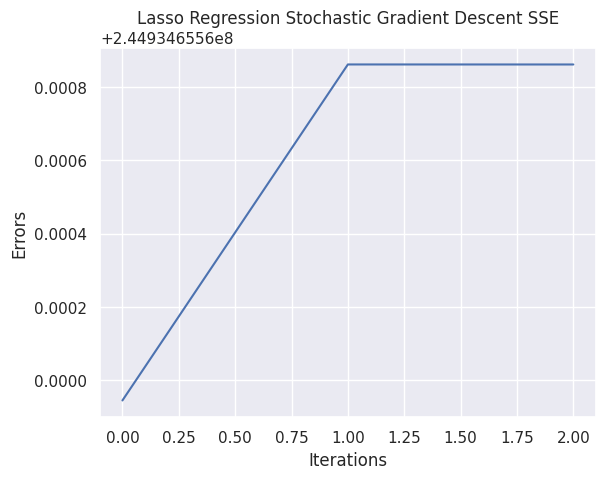

Training Data: SSE is 244934655.62686217, RMSE is 143.48496229880348
Test Data: SSE is 101286192.75987113, RMSE is 140.92564633895833
Coefficients of Columns:
[187.35913275  29.72932368 -13.06494261   7.44579172  41.40050514
  -9.60934231  -7.4287531  -20.09474787  60.53139212 -48.09731237
  -1.06169108]


In [75]:
lasso_stochastic_grad = LassoRegressionSGD(X = X, y = y)
lasso_stochastic_grad.fit()

### Neural Network

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_train.max()

1.0

In [78]:
model=Sequential()

model.add(Dense(10,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [79]:
model.fit(x=X_train, y=y_train, epochs=150, batch_size=10,validation_data=(X_test,y_test))

Epoch 1/150
1190/1190 [==============================] - 6s 4ms/step - loss: 27913.2695 - val_loss: 19941.6602
Epoch 2/150
1190/1190 [==============================] - 4s 4ms/step - loss: 19847.1465 - val_loss: 18601.7637
Epoch 3/150
1190/1190 [==============================] - 5s 4ms/step - loss: 19197.9766 - val_loss: 18198.6035
Epoch 4/150
1190/1190 [==============================] - 4s 4ms/step - loss: 18755.0176 - val_loss: 17693.6289
Epoch 5/150
1190/1190 [==============================] - 4s 3ms/step - loss: 17815.9258 - val_loss: 16501.8457
Epoch 6/150
1190/1190 [==============================] - 4s 3ms/step - loss: 16459.8730 - val_loss: 15001.7666
Epoch 7/150
1190/1190 [==============================] - 5s 4ms/step - loss: 15546.8623 - val_loss: 14727.5762
Epoch 8/150
1190/1190 [==============================] - 3s 3ms/step - loss: 15062.5039 - val_loss: 14507.1416
Epoch 9/150
1190/1190 [==============================] - 4s 3ms/step - loss: 14697.7422 - val_loss: 13735.2686
E

<Axes: >

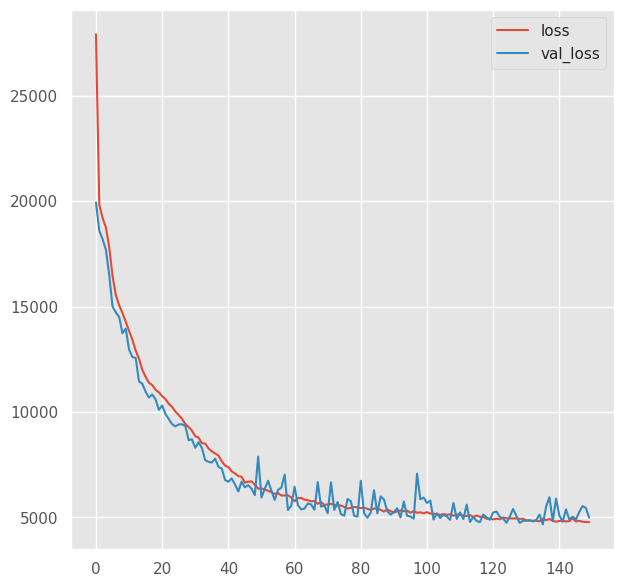

In [80]:
plt.style.use("ggplot")
pd.DataFrame(model.history.history).plot(figsize=(7,7))

In [81]:
model.evaluate(X_train,y_train)

372/372 [==============================] - 1s 2ms/step - loss: 4633.0879


4633.087890625

In [82]:
model.evaluate(X_test,y_test)

160/160 [==============================] - 0s 2ms/step - loss: 4992.5962


4992.59619140625

In [83]:
predictions = model.predict(X_test)
predictions_df = pd.DataFrame(np.ravel(predictions),columns=["Predictions"])
comparison_df = pd.concat([pd.DataFrame(np.array(y_test),columns=["Real Values"]), predictions_df],axis=1)
comparison_df

160/160 [==============================] - 0s 2ms/step


,Real Values,Predictions
0,530,579.443665
1,465,391.503998
2,1,4.962271
3,62,43.981197
4,8,14.527803
...,...,...
5095,89,114.835846
5096,311,543.818115
5097,137,167.823837
5098,253,330.593018


In [84]:
np.array(y_test)

array([530, 465,   1, ..., 137, 253, 468])

In [91]:
from sklearn.metrics import r2_score



# Calculate R-squared score for train
r2_train = r2_score(model.predict(X_train),y_train)

# Calculate RMSE for train
mse_train = mean_squared_error(model.predict(X_train),y_train)

# Calculate RMSE for train
rmse_train = np.sqrt(mse_train)

print('R-squared Score for train:',r2_train)
print('RMSE for train',rmse_train)

372/372 [==============================] - 1s 2ms/step
R-squared Score for train: 0.8172516173724427
RMSE for train 68.066801738412


In [88]:

# Calculate R-squared score for test
r2_test = r2_score(comparison_df['Real Values'], comparison_df['Predictions'])

# Calculate RMSE for test
mse_test = mean_squared_error(comparison_df['Real Values'], comparison_df['Predictions'])
# Calculate RMSE
rmse_test = np.sqrt(mse)


# Print the R-squared score
print(f'R-squared Score for test: {r2_test}')
# Print the RMSE
print(f'RMSE for test: {rmse_test}')

R-squared Score for test: 0.8258136670820689
RMSE for test: 70.65830393857624


## Conclusion

`Neural Network` (rmse : 70.65) and `Linear regression` shows promising result, therefore it can be used to solve this problem.

Bike rental count is high during week days than on weekend.

Bike demand shows peek around 8-9 AM in the morning and 6 - 7pm in the evening.

People prefer to rent bike more in summer than in winter.

Bike demand is more on clear days than on snowy or rainy days.

Temperature range from 22 to 25(°C) has more demand for bike.

'Hour', 'Temperature(°C)', 'Humidity', 'Wind_speed','Visibility ', 'Dew_point_temperature', 'Solar_Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'month', 'day of week ' regulates bike demand.